In [1]:
import os
os.chdir("/Coding/Spectrum4Geo/") #Change to ProjectDirectory (One Directory above)

In [2]:
import os
import torch
import pickle
import importlib
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.transforms.functional import resize

from spectrum4geo.dataset.training import SatSpectroTrainDataset, SpectroSimDataset
from spectrum4geo.dataset.evaluation import SatEvalDataset, SpectroEvalDataset
from spectrum4geo.transforms import get_transforms_val_sat, get_transforms_val_spectro
from spectrum4geo.transforms import get_transforms_train_sat, get_transforms_train_spectro 

@dataclass
class Configuration:
    img_size: int = 384         # for satallite images
    patch_time_steps = 1024     # Image size for spectograms (Width)
    n_mels = 128                # image size for spectograms (Height)
    sr_kHz = 48
    batch_size: int = 16        # keep in mind real_batch_size = 2 * batch_size
    data_folder = "data"        # Dataset
    # Augment Images
    prob_rotate: float = 0.75          # rotates the sat image 
    prob_flip: float = 0.5             # flipping the sat image 
    num_workers: int = 0 if os.name == 'nt' else 4 
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu' 
    mean=[1, 1, 1]
    std=[1, 1, 1]

    # Shuffeling test
    shuffeling = True
    neighbour_select: int = 64                  # max selection size from pool
    neighbour_range: int = 128                  # pool size for selection
    gps_dict_path: str = 'data/gps_dict.pkl'    # path to pre-computed distances
    

config = Configuration()

img_size = config.img_size
img_size_sat = (img_size, img_size)
img_size_spectro = (config.patch_time_steps, config.n_mels)

# Transforms
sat_transforms_train = get_transforms_train_sat(img_size_sat,
                                                mean=config.mean,
                                                std=config.std,
                                                )

spectro_transforms_train = get_transforms_train_spectro(img_size_spectro,
                                                        mean=config.mean,
                                                        std=config.std,
                                                        )

# Eval
sat_transforms_val = get_transforms_val_sat(img_size_sat,
                                            mean=config.mean,
                                            std=config.std,
                                            )

spectro_transforms_val = get_transforms_val_spectro(mean=config.mean,       
                                                    std=config.std
                                                    )    



train_dataset = SatSpectroTrainDataset(data_folder=config.data_folder ,
                                       split_csv='train_df.csv',
                                       transforms_sat_image=sat_transforms_train,
                                       transforms_spectrogram=spectro_transforms_val,
                                       patch_time_steps=config.patch_time_steps,
                                       sr_kHz=config.sr_kHz,
                                       n_mels=config.n_mels,
                                       prob_flip=config.prob_flip,
                                       prob_rotate=config.prob_rotate,
                                       shuffle_batch_size=config.batch_size
                                       )
              

train_dataloader = DataLoader(train_dataset,
                              batch_size=config.batch_size,  
                              shuffle=False,
                              num_workers=config.num_workers,
                              pin_memory=True
                              )


spectro_dataset_sim = SpectroSimDataset(data_folder=config.data_folder,
                                        split_csv='train_df.csv',
                                        transforms=spectro_transforms_val,
                                        patch_time_steps=config.patch_time_steps,
                                        sr_kHz=config.sr_kHz,
                                        n_mels=config.n_mels,
                                        )
    
spectro_dataloader_sim = DataLoader(spectro_dataset_sim,
                                    batch_size=config.batch_size,
                                    num_workers=config.num_workers,
                                    shuffle=False,
                                    pin_memory=True
                                    )

print("Spectrogram Images Train:", len(spectro_dataset_sim))
print("Spectrogram Images Sim:", len(spectro_dataset_sim))

/home/j0kr0017/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/j0kr0017/conda/lib/python3.12/site-packages/pydantic/main.py:328: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Spectrogram Images Train: 35625
Spectrogram Images Sim: 35625


Plotte Train Dataloader Bilder

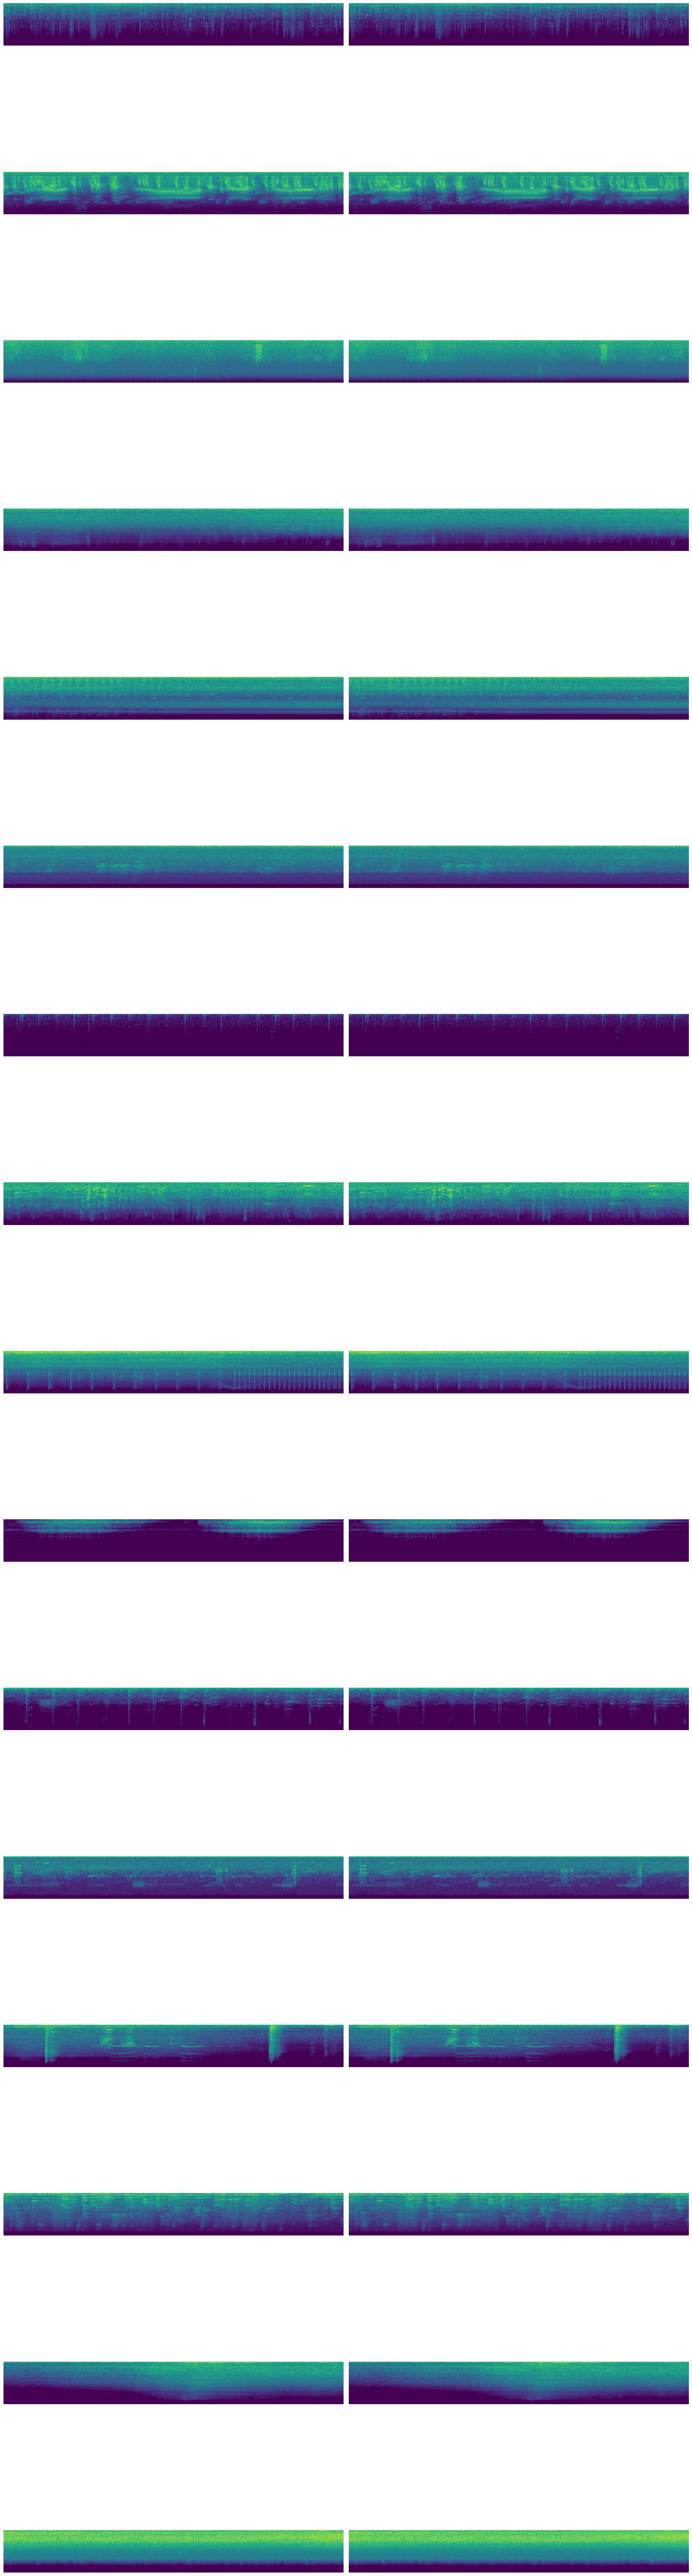

In [4]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def plot_images(dataloader, dataloader_sim, spectro_den_b=True):
    # Nimm nur einen Batch aus dem Dataloader
    sat_images, spectrograms, _ = next(iter(dataloader))
    spectrograms_sim, _ = next(iter(dataloader_sim))
    
    batch_size = len(spectrograms)
    
    fig, axs = plt.subplots(nrows=batch_size, ncols=2, figsize=(20, 5 * batch_size))  # Zwei Spalten für Original und Simuliert
    axs = axs.flatten()

    for i, (spectrogram, spectrogram_sim) in enumerate(zip(spectrograms, spectrograms_sim)):
        if spectro_den_b:
            spectrogram = denormalize(spectrogram, config.mean, config.std)
            spectrogram_sim = denormalize(spectrogram_sim, config.mean, config.std)

        # Plot the original spectrogram
        ax = axs[i * 2]
        ax.imshow(spectrogram.permute(1, 2, 0).numpy())  # Annahme: Spektrogramme sind im CHW-Format
        ax.axis('off')

        # Plot the simulated spectrogram
        ax = axs[i * 2 + 1]
        ax.imshow(spectrogram_sim.permute(1, 2, 0).numpy())  # Annahme: Spektrogramme sind im CHW-Format
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Beispielaufruf
for i in [35]:
    train_dataloader.dataset.set_random_seed(i)
    spectro_dataloader_sim.dataset.set_random_seed(i)
    plot_images(train_dataloader, spectro_dataloader_sim, spectro_den_b=True)